In [3]:
import numpy as np
import pandas as pd
from glob import glob
import datetime
from pyproj import Transformer
import matplotlib.pyplot as plt
import wradlib as wrl
import re

In [4]:
# raw = wrl.io.read_generic_hdf5('C:/Users/sverrirhd/vedurgogn/radar/2020/202001/2020010100050000dBZ.vol.hdf5') # 2020 01 01 00 05
# az_angle_bins = np.array([[float(j) for j in (i.split(':'))] for i in raw['dataset1/how']['attrs']['azangles'].decode().split(',')])
# attributes = raw['dataset1/data1/what']['attrs']
# gain = attributes['gain']
# offset = attributes['offset']

In [5]:
# For working with coordinates
transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit

# URLS
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
URL_gauge_2020_file = URL_gauge_data + 'clean2020data1475.csv'
URL_saved_sensor_data = URL_gauge_data + 'hbs_lysigogn.csv'
DIR_rain_gauges = glob(URL_gauge_data + '*cleaned*')

DIR_data = 'C:/Users/sverrirhd/vedurgogn/'
URL_dates = glob(DIR_data + '??_file_dates.npy')
URL_missing_indexes = glob(DIR_data + '??_missing_indexes.npy')
URL_pixel_coords_save = DIR_data + 'radar_pixel_coords.npy'

def get_dates(URL):
    dates = np.load(URL,allow_pickle=True)
    return dates

def get_missing(URL):
    missing_indexes = np.load(URL)
    return missing_indexes

def to_rainfall(radar_data,offset,gain,a,b):
    return wrl.zr.z_to_r(wrl.trafo.idecibel(offset + gain * radar_data), a=a, b=b)

In [6]:
DIR_CAPPI = 'C:/Users/sverrirhd/OneDrive/CAPPI/'

urls_cappi = np.array(glob(DIR_CAPPI + 'CAPPI*'))
urls_descr = np.array(glob(DIR_CAPPI + 'descriptive_data*'))
urls_probl = np.array(glob(DIR_CAPPI + 'problematic_indexes*'))
urls_urls = np.array(glob(DIR_CAPPI + 'urls*'))

urls_cappi_2020 = urls_cappi[['2020' in i for i in urls_cappi]]
urls_descr_2020 = urls_descr[['2020' in i for i in urls_descr]]
urls_probl_2020 = urls_probl[['2020' in i for i in urls_probl] ]
urls_urls_2020 = urls_urls[['2020' in i for i in urls_urls]]

urls_cappi = urls_cappi[[url not in urls_cappi_2020 for url in urls_cappi]]
urls_descr = urls_descr[[url not in urls_descr_2020 for url in urls_descr]]
urls_probl = urls_probl[[url not in urls_probl_2020 for url in urls_probl]]
urls_urls = urls_urls[[url not in urls_urls_2020 for url in urls_urls]]

In [7]:
df_file_urls = pd.DataFrame([urls_cappi,urls_descr,urls_probl,urls_urls]).T
df_file_urls.columns = ['CAPPI','descriptive_data','problematic_indexes','urls']
df_file_urls.loc[:,'yearmonth'] = df_file_urls.CAPPI.str.findall('[0-9][0-9][0-9][0-9][0-9][0-9]').apply(lambda x : x[0])

df_file_urls.loc[:,'filetype'] = df_file_urls.CAPPI.str.findall('hdf5').apply(lambda x: 'hdf5' if len(x) > 0 else 'h5')

AttributeError: Can only use .str accessor with string values!

# Remove duplicate months

In [8]:
df_file_urls

Empty DataFrame
Columns: [CAPPI, descriptive_data, problematic_indexes, urls]
Index: []

# Get number of files per month

In [ ]:
n_urls = {}
for index,row in df_file_urls.iterrows():
    url = row['urls']
    year_month = row['yearmonth']
    filetype = row['filetype']
    urls_tmp = np.load(url,allow_pickle=True)
    # print(urls_tmp)
    n_urls_tmp = len(urls_tmp)
    n_urls[(year_month,filetype)] = n_urls_tmp


# Batched histogram

In [ ]:
possible_values = []
for i in range(0,256):
    for gain,offset in [(0.4,-30),(0.5,-32)]:
        org_value = i*gain + offset
        possible_values.append(org_value)
possible_values = np.array(possible_values)
min_poss,max_poss = min(possible_values),max(possible_values)
print('most extreme possible values after transformation:',min_poss,max_poss)


In [ ]:
# 255 * 0.4 - 30,255 * 0.5 - 32


In [ ]:
# np.round(0.5,0),np.round(-0.5,0)

In [ ]:
pixel_space_mask = np.full((602,602),False)
for i in range(0,602):
    for ii in range(0,602):
        distance = np.sqrt((i-301.5)**2 + (ii-301.5)**2)
        pixel_space_mask[i,ii] = distance < (301.5*240/250)
plt.imshow(pixel_space_mask*1)


In [ ]:
np.histogram(np.arange(0,256),bins = np.arange(-1,256+1))

In [ ]:
# pixel_hisograms = {}

In [ ]:

pixel_space_mask_flat = pixel_space_mask.ravel()
for index,row in df_file_urls.iterrows():
    
    print(index,'/',len(df_file_urls),year_month,filetype)
    urls = row['urls']
    year_month = row['yearmonth']
    filetype = row['filetype']
    CAPPI_url = row['CAPPI']
    
    key = (year_month,filetype)
    if key in pixel_hisograms.keys():
        continue
    
    
    CAPPI_flat = np.load(CAPPI_url).reshape(-1,602**2)
    p = CAPPI_flat.shape[1]
    
    pixel_space = np.zeros((p,256),dtype=int)
    
    for i in range(p):
        mask = pixel_space_mask_flat[i]
        if mask:
            pixel_values = CAPPI_flat[:,i]
            pixel_space[i,:] = np.histogram(pixel_values,bins = np.arange(0,256+1))[0]
            
    pixel_hisograms[key] = pixel_space
        
    print(CAPPI_flat.shape)
    
    n_urls = n_urls_tmp

In [ ]:
np.save('pixel_histograms_for_each_month',pixel_hisograms)

In [ ]:
pixel_hisograms[('201501','h5')]

In [ ]:
CAPPI_tensor = CAPPI_tensor.reshape(-1,602**2)
CAPPI_tensor.shape

In [ ]:
# pixel_space_mask

In [ ]:
from scipy.spatial.distance import mahalanobis
def pixel_space_to_mask(pixel_space,pixel_space_mask,threshold_factor= 3):
    pixel_space_mask_flat = pixel_space_mask.ravel()
    mean_array = pixel_space[pixel_space_mask_flat].mean(axis=0)
    std_array = pixel_space[pixel_space_mask_flat].std(axis=0)
    V = np.cov(pixel_space[pixel_space_mask_flat].T)
    IV = np.linalg.pinv(V)
    pixel_distances = []
    for i in pixel_space:
        distance = mahalanobis(mean_array, i,IV)
        pixel_distances.append(distance)
    pixel_distances = np.array(pixel_distances)
    
    threshold = np.mean(pixel_distances[pixel_space_mask_flat]) + threshold_factor*np.std(pixel_distances[pixel_space_mask_flat])
    valid = (pixel_distances < threshold) & pixel_space_mask_flat
    tensor_mask = np.array(valid).reshape(602,602)


    plt.figure(figsize=(12,12))
    plt.scatter(np.arange(len(pixel_distances[pixel_space_mask_flat])),pixel_distances[pixel_space_mask_flat],
                color='red',
                edgecolors = 'black')
    plt.hlines(threshold,0,len(pixel_distances))
    plt.xlabel('Location Index')

    plt.ylabel('Mahalanobis distance\nto mean pixel histogram')
    plt.show()
    return tensor_mask



In [ ]:
tensor_masks_all_histograms = {key:pixel_space_to_mask(pixel_hisograms[key],pixel_space_mask,3) for key in pixel_hisograms}

In [ ]:
np.save('tensor_masks_for_all_months',tensor_masks_all_histograms)

# Color pixels by how often they were considered an outlier

In [ ]:
running_total = np.zeros(p,dtype = int)
for key in tensor_masks_all_histograms.keys():
    running_total += (~tensor_masks_all_histograms[key].ravel())*1
    
running_total_image = np.array(running_total).reshape(602,602)

plt.figure(figsize=(10,10))
plt.imshow(pixel_space_mask*running_total_image[::-1])
plt.scatter(300,300,color = 'r')

outlier_thresh_base = running_total_image.copy()

plt.figure(figsize=(15,15))
plt.imshow(pixel_space_mask * (outlier_thresh_base**0.5))

In [ ]:
np.save('running_total_mask',running_total_image)
np.save('radar_range_mask',pixel_space_mask)

# Check outlier frequency around area of interest

In [ ]:
import geopandas as gpd
postnr = gpd.read_file('../Radar data analysis/Radar visualization/Shapefiles/postnr/postnrs.shp')
coords = np.load('./CAPPI_pixel_coords.npy')

In [ ]:
transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit
sitecoords = (-22.636, 64.025, 45.0)
radar_x,radar_y = transformer_gps_isl.transform(sitecoords[1],sitecoords[0])
gauge_x,gauge_y = transformer_gps_isl.transform(64.1275,-21.902)
# x_max,y_max = coords[:,0].max(),coords[:,1].max()
# x_min,y_min = coords[:,0].min(),coords[:,1].min()
radar_width_in_image = (602*240/250+1)
pixel_distance = ((coords[:,:2] - [gauge_x,gauge_y])**2).sum(axis=1)**0.5
idx_closest_pixel = pixel_distance.argmin()
pixel_distance[idx_closest_pixel],idx_closest_pixel

gauge_idx,gauge_idy = idx_closest_pixel//602,idx_closest_pixel%602


In [ ]:

n_1 = [i[gauge_idx-1,gauge_idy-1] for i in tensor_masks_all_histograms.values()]
n_2 = [i[gauge_idx-1,gauge_idy+1] for i in tensor_masks_all_histograms.values()]
n_3 = [i[gauge_idx-1,gauge_idy] for i in tensor_masks_all_histograms.values()]
n_4 = [i[gauge_idx+1,gauge_idy-1] for i in tensor_masks_all_histograms.values()]
n_5 = [i[gauge_idx+1,gauge_idy+1] for i in tensor_masks_all_histograms.values()]
n_6 = [i[gauge_idx+1,gauge_idy] for i in tensor_masks_all_histograms.values()]
n_7 = [i[gauge_idx,gauge_idy-1] for i in tensor_masks_all_histograms.values()]
n_8 = [i[gauge_idx,gauge_idy+1] for i in tensor_masks_all_histograms.values()]
n_9 = [i[gauge_idx,gauge_idy] for i in tensor_masks_all_histograms.values()]
neighbours = np.array([n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9])
plt.plot(neighbours.mean(axis = 0)/9)

# Check raw data and see if this period stands out as being problematic

In [ ]:
neighbours.mean(axis = 0)[37:41]

In [ ]:
key_list = list(tensor_masks_all_histograms.keys())

In [ ]:
# for key in [key_list[40],key_list[41]]:
#     plt.imshow(tensor_masks_all_histograms[key][::-1])
#     plt.show()

In [7]:
cappi_test_0 = np.load(df_file_urls.iloc[37,0])
cappi_test_1 = np.load(df_file_urls.iloc[38,0])
cappi_test_2 = np.load(df_file_urls.iloc[39,0])
cappi_test_3 = np.load(df_file_urls.iloc[40,0])

# cappi_test_0
# cappi_test_1
# cappi_test_2
# cappi_test_3

In [2]:
1.67e-4, 2.33e-5

(0.000167, 2.33e-05)

In [ ]:
pia = wrl.atten.correct_attenuation_constrained(data_no_clutter, a_max=1.67e-4, a_min=2.33e-5,
                                                n_a=100, b_max=0.7, b_min=0.65, n_b=6,
                                                gate_length=1., constraints=[wrl.atten.constraint_dbz,
                                                                             wrl.atten.constraint_pia],
                                                constraint_args=[[59.0],[20.0]])
data_attcorr = data_no_clutter + pia

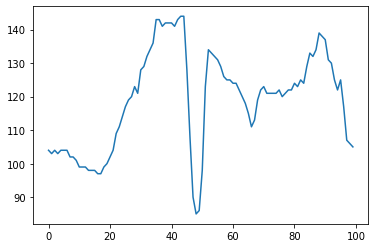

In [47]:
plt.plot(cappi_test_1[101][400,100:200].ravel())

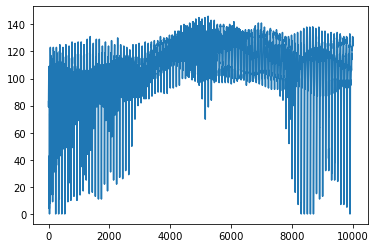

In [45]:
plt.plot(cappi_test_1[101][350:450,100:200].ravel())

array(['C:/Users/sverrirhd/vedurgogn//radar\\201802\\2018020201250000dBZ.vol.hdf5'],
      dtype=object)

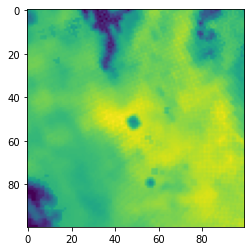

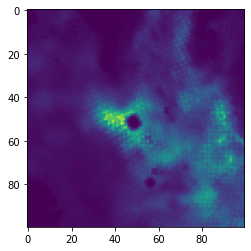

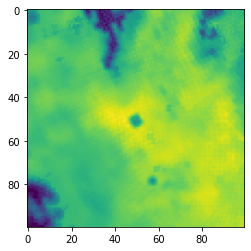

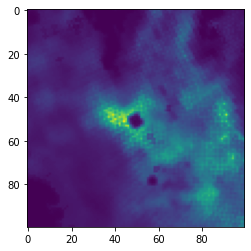

In [54]:
plt.imshow(cappi_test_1[101][350:450,100:200])
plt.show()
plt.imshow(compute_rain(cappi_test_1[101][350:450,100:200]))
plt.show()

plt.imshow(cappi_test_2[101][350:450,100:200])
plt.show()
plt.imshow(compute_rain(cappi_test_2[101][350:450,100:200]))
plt.show()

# Comments on images above:
- After going through the raw data I've seen that this exact artifact is present there and is not fixed with any sort of attenuation correction or otherwise 

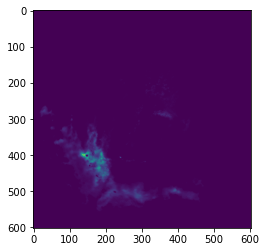

In [37]:
plt.imshow(compute_rain(cappi_test_1[101]))

In [58]:
# URL_imgs = './images/rain_test/'
# compute_rain = lambda x : to_rainfall(x,-32,0.5,200,1.6)
# for i in range(100,900):
#     file_name = f'{URL_imgs}samples_{i}.png'
#     if len(glob(file_name)) > 0:
#         continue
#     f,axes = plt.subplots(2,2,figsize=(12,12))
#     axes = axes.ravel()
    
#     axes[0].imshow(compute_rain(cappi_test_0[i]),vmin = 0, vmax = 15)
#     axes[1].imshow(compute_rain(cappi_test_1[i]),vmin = 0, vmax = 15)
#     axes[2].imshow(compute_rain(cappi_test_2[i]),vmin = 0, vmax = 15)
#     axes[3].imshow(compute_rain(cappi_test_3[i]),vmin = 0, vmax = 15)
#     plt.savefig(file_name)
#     plt.clf()

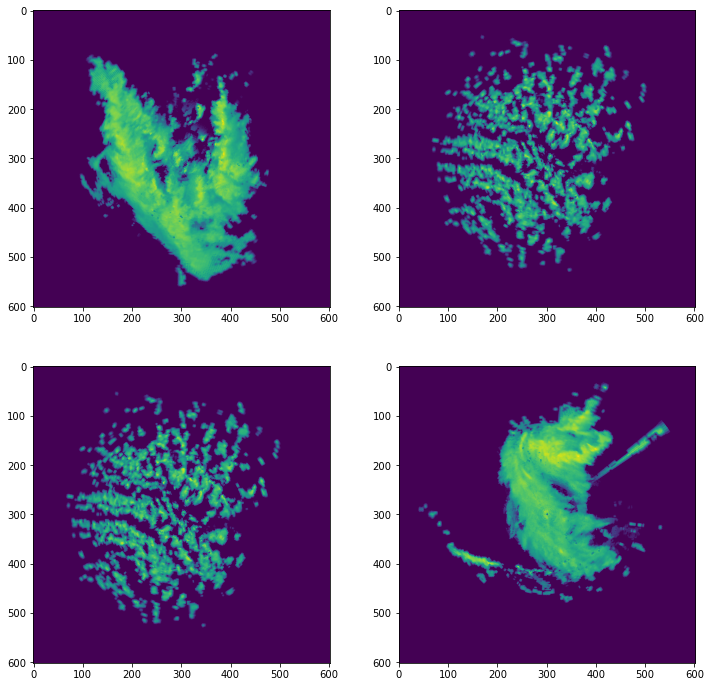

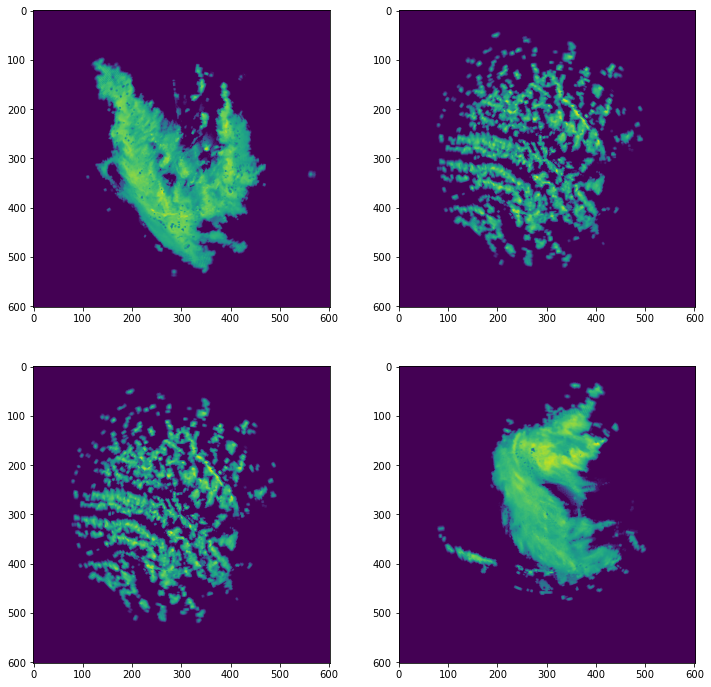

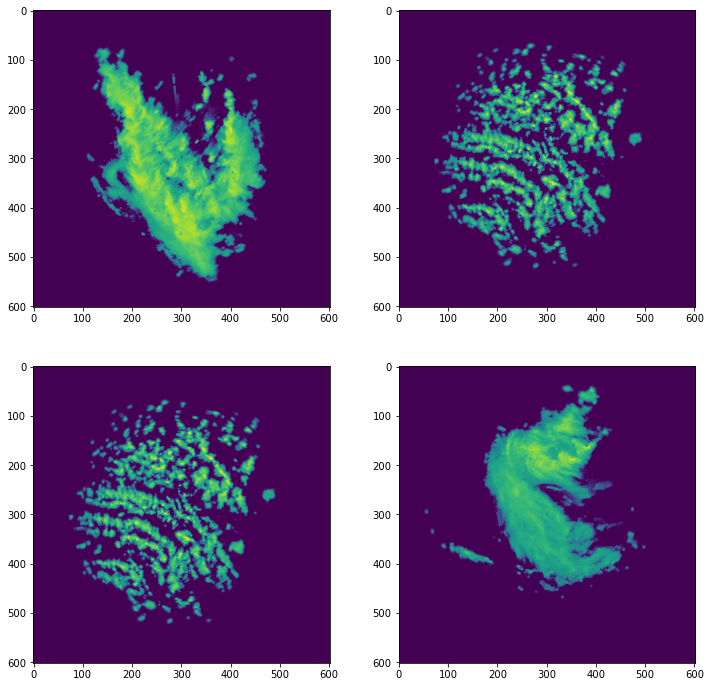

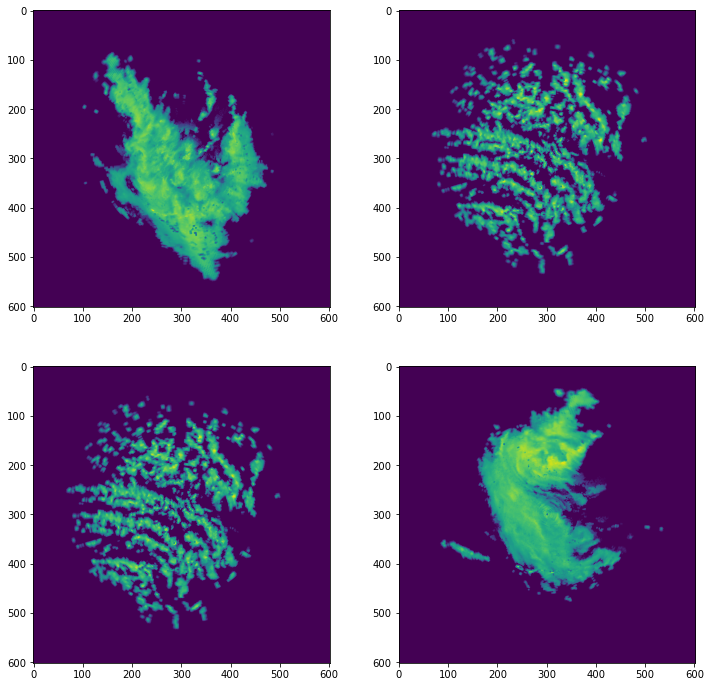

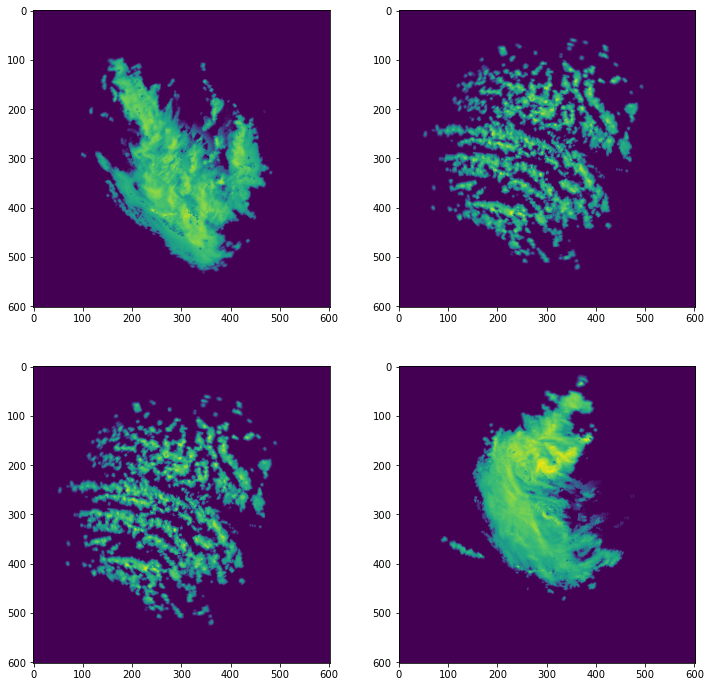

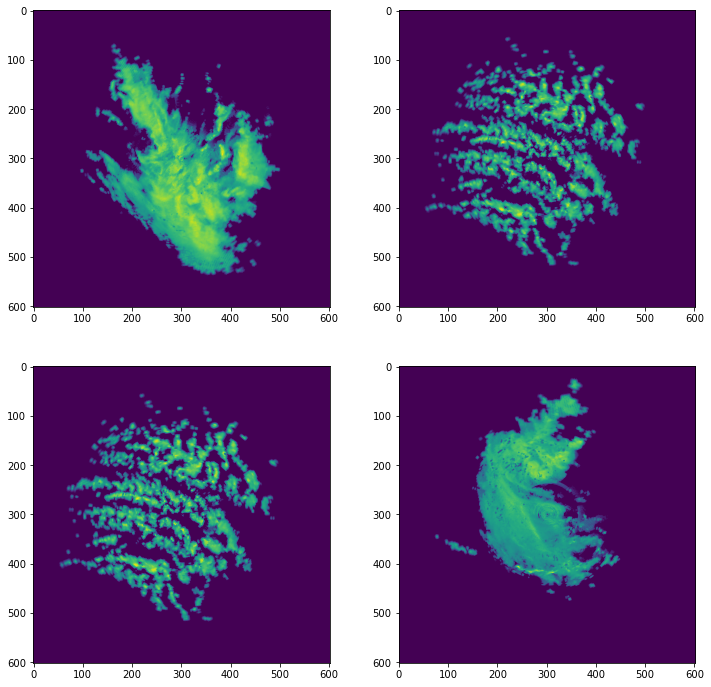

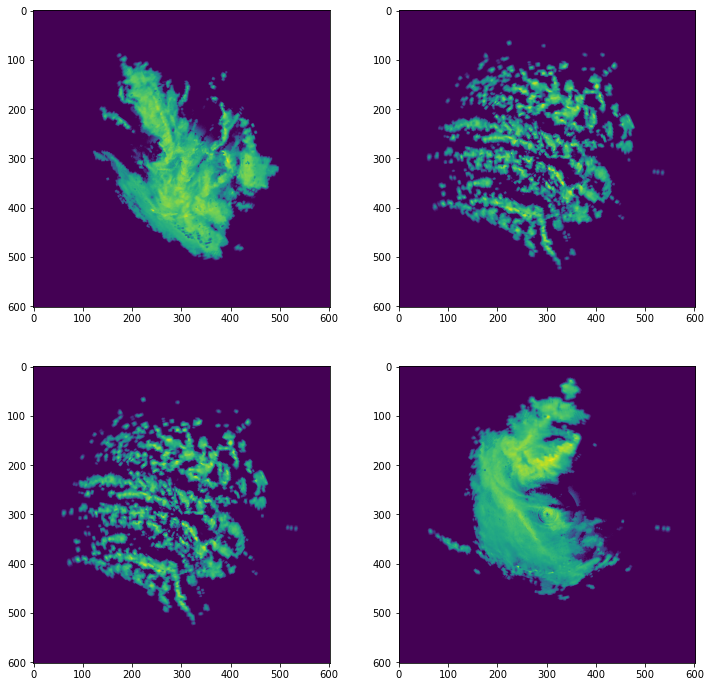

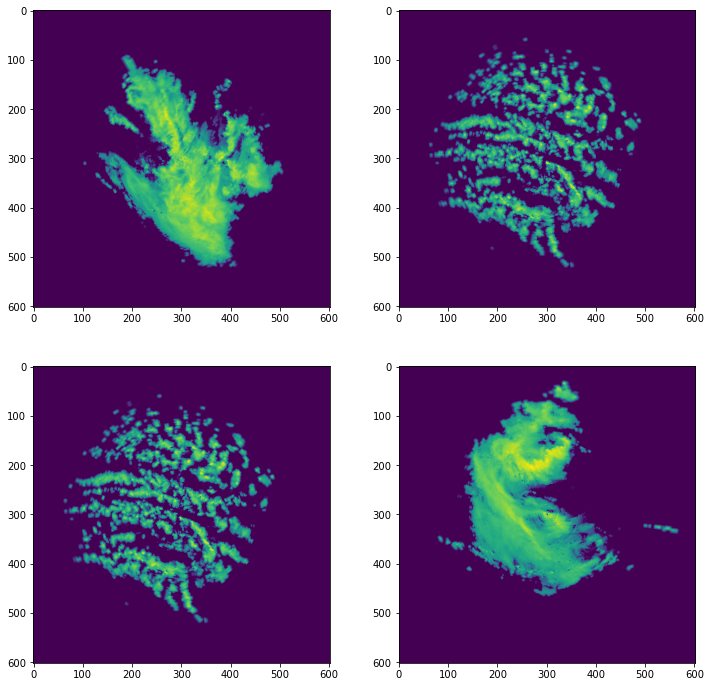

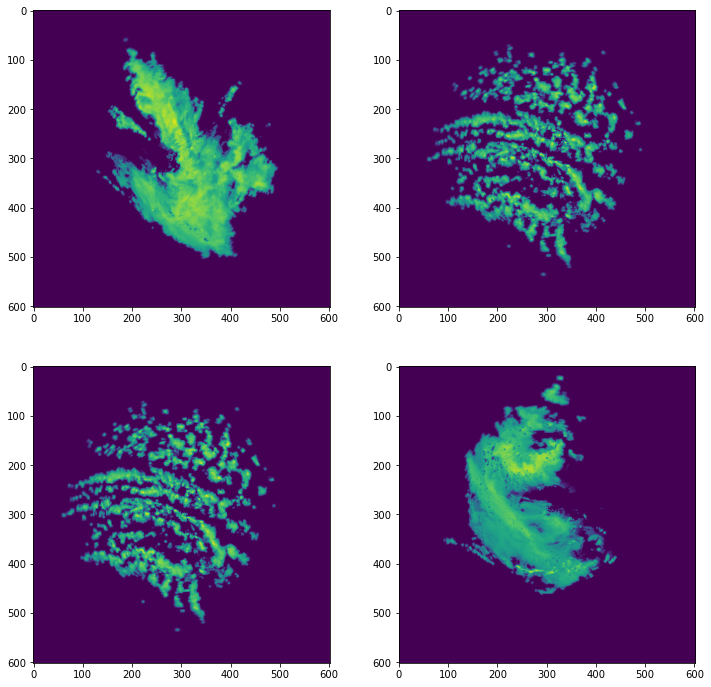

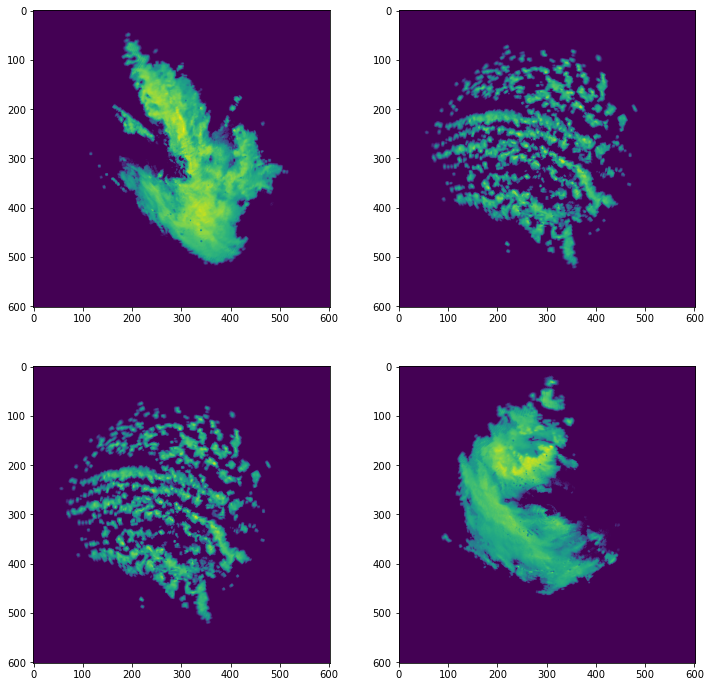

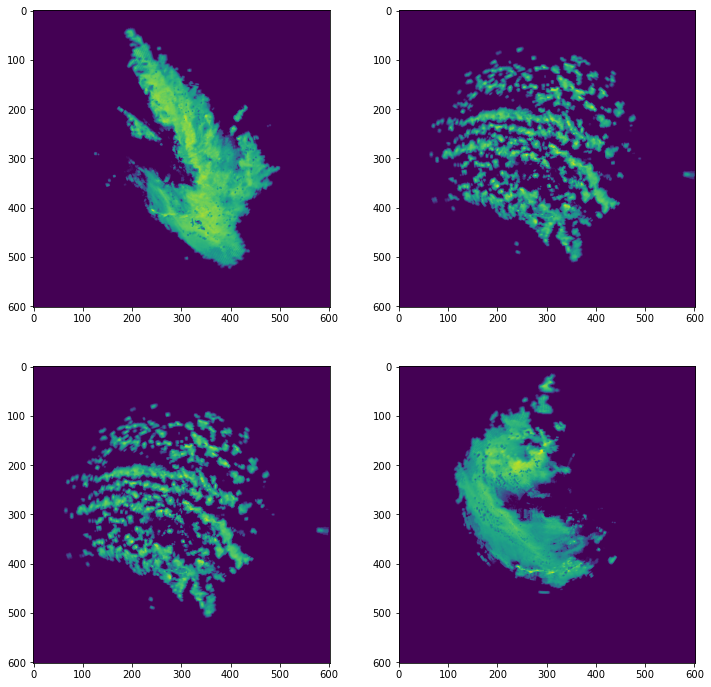

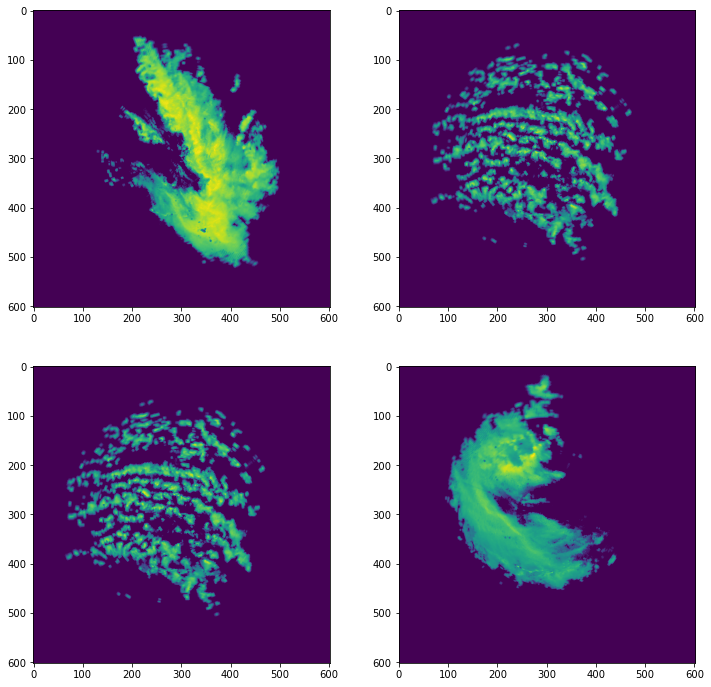

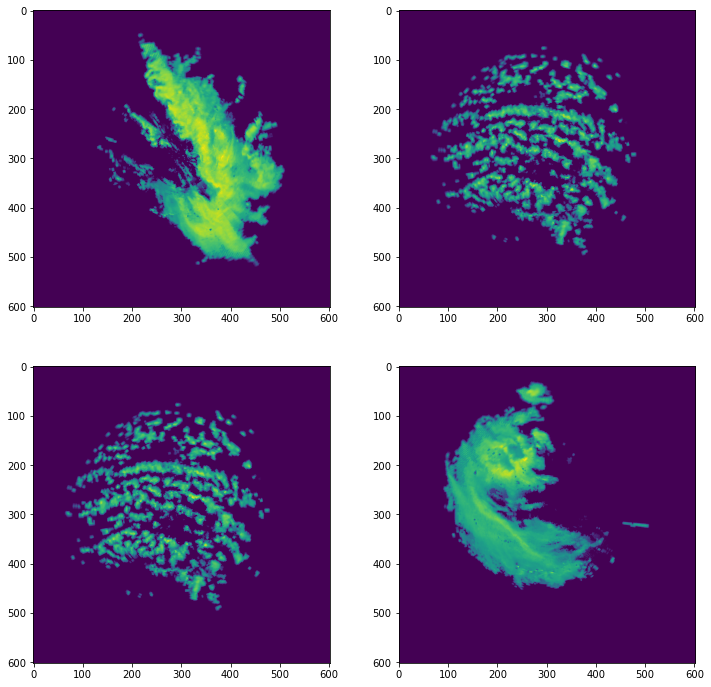

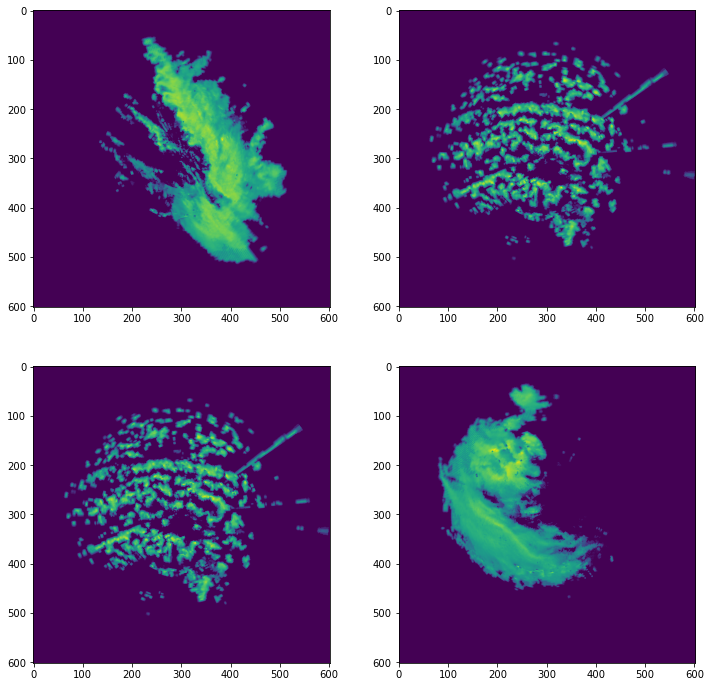

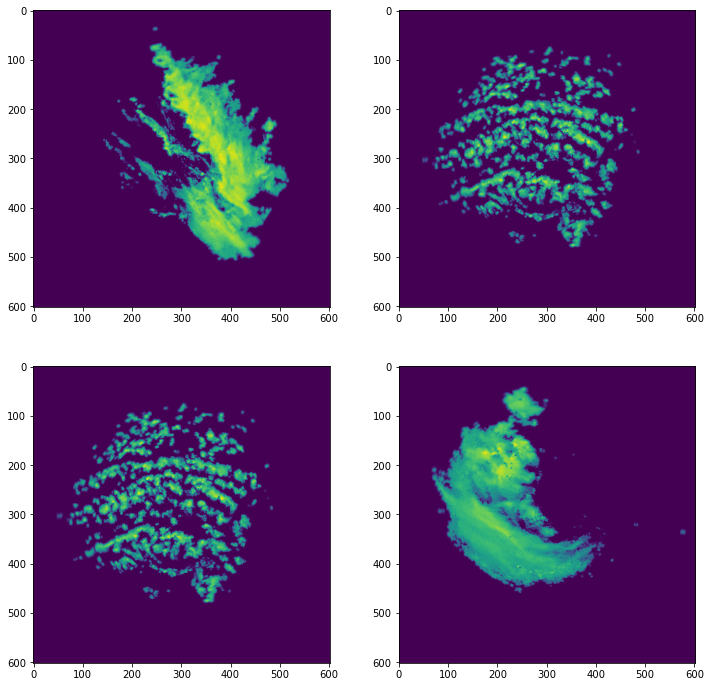

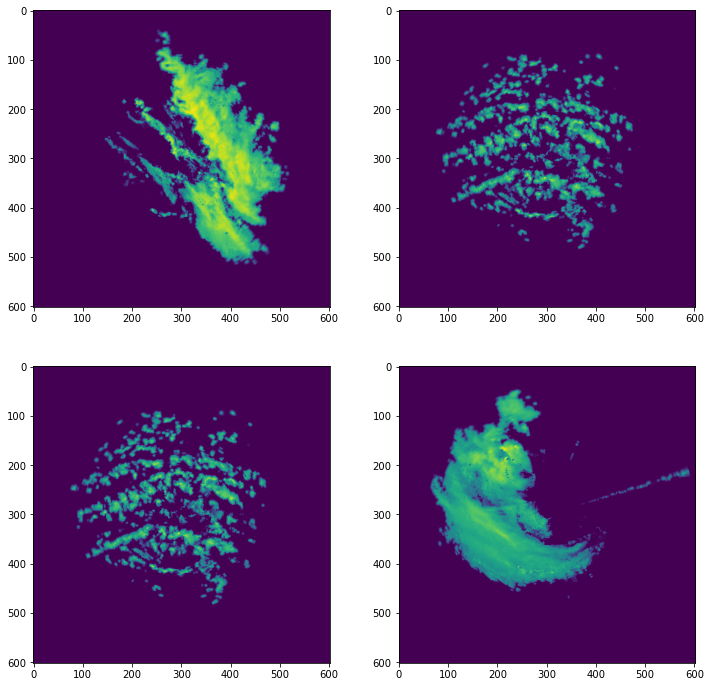

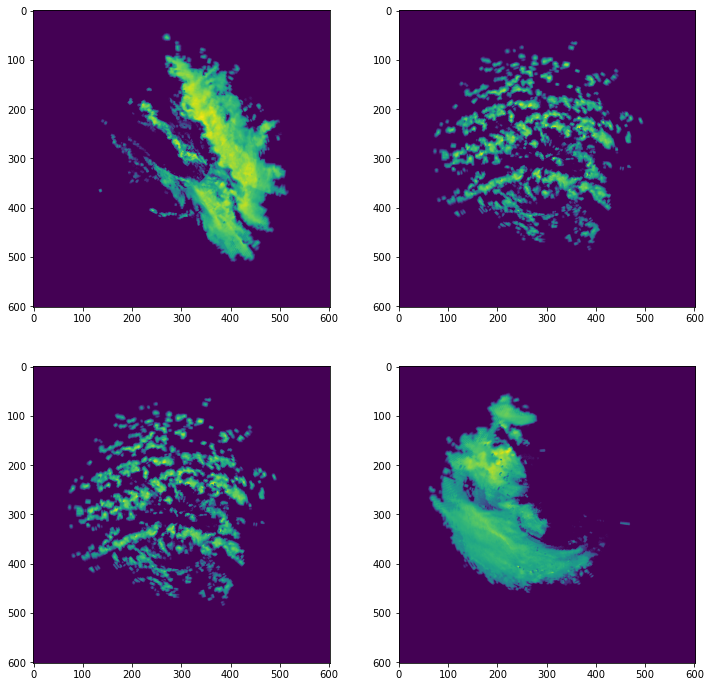

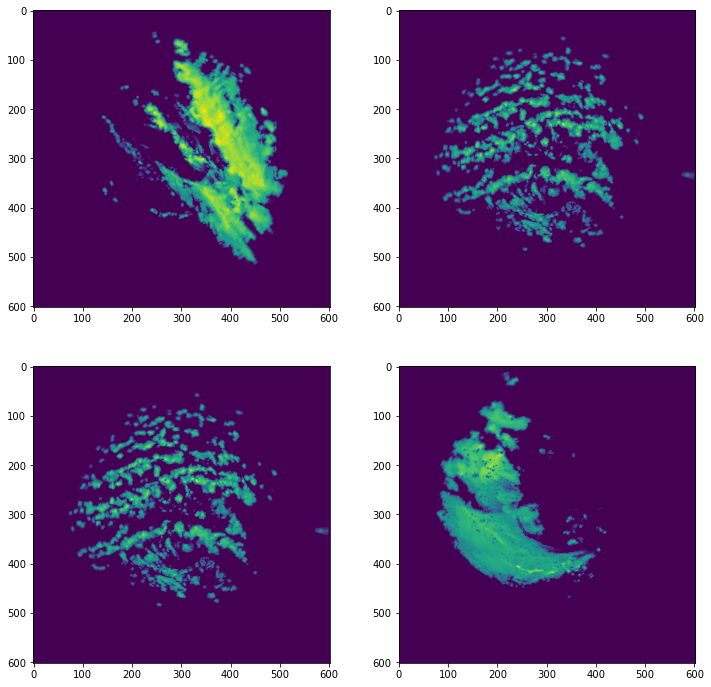

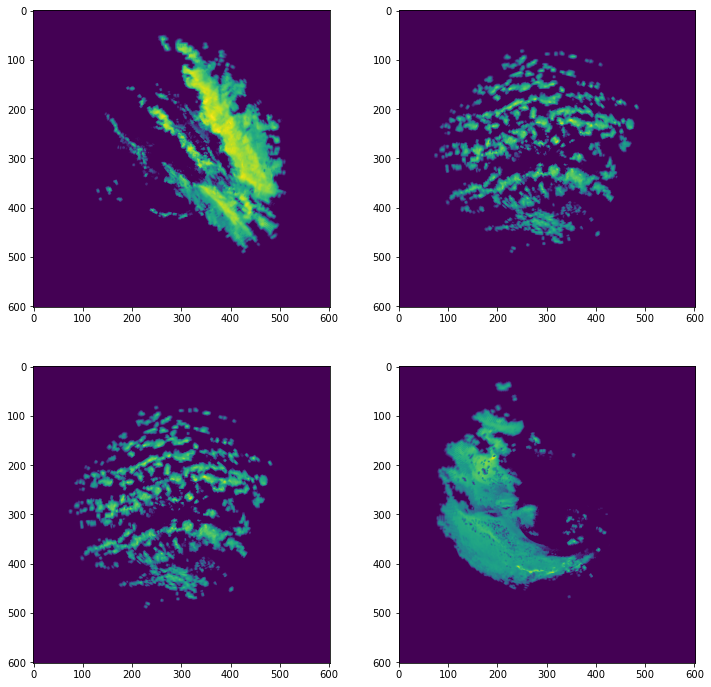

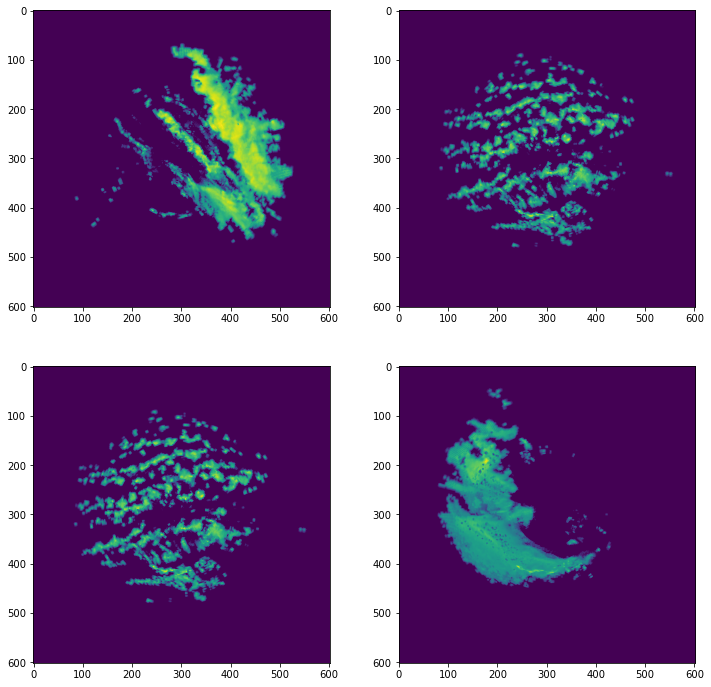

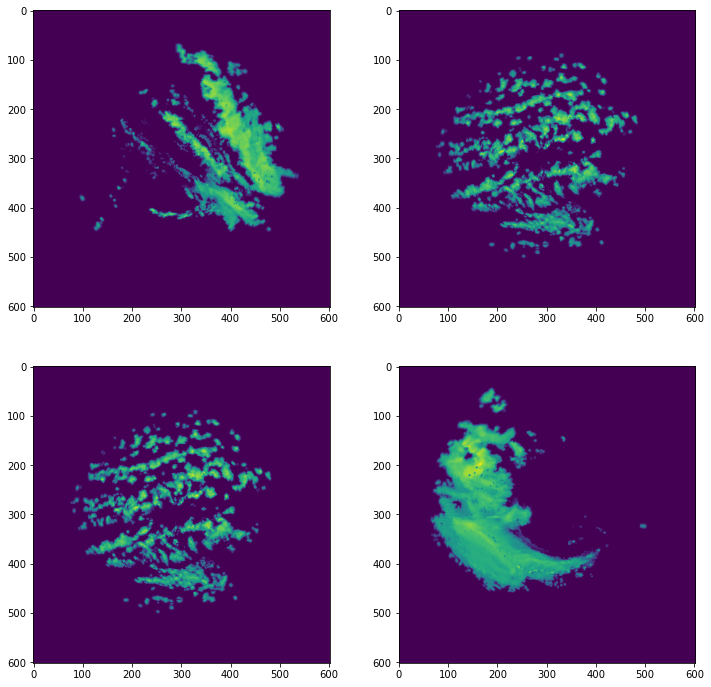

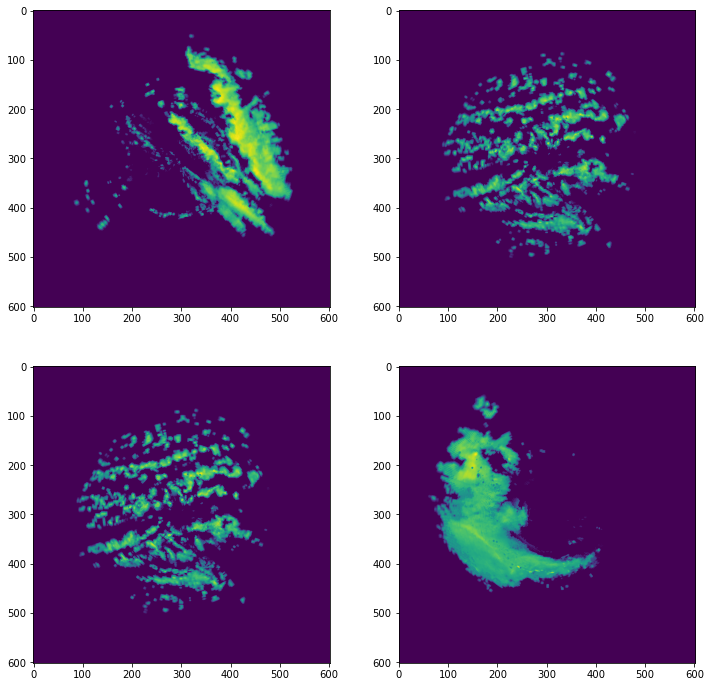

Error in callback <function flush_figures at 0x000001521FA2B820> (for post_execute):


KeyboardInterrupt: 

In [470]:
URL_imgs = './images/outlier_test/'

for i in range(100,900):
    file_name = f'{URL_imgs}samples_{i}.png'
    if len(glob(file_name)) > 0:
        continue
    f,axes = plt.subplots(2,2,figsize=(12,12))
    axes = axes.ravel()
    axes[0].imshow(cappi_test_0[i])
    axes[1].imshow(cappi_test_1[i])
    axes[2].imshow(cappi_test_2[i])
    axes[3].imshow(cappi_test_3[i])
    plt.savefig(file_name)

# Conclusion: No obvious problems with data during this period and both h5 and hdf5 files look more or less identical

In [ ]:
plt.figure(figsize=(15,15))
# postnr.geometry.apply(lambda x : x.boundary).plot(ax = plt.gca())

plt.scatter(coords[:,0],coords[:,1],c = running_total_image.ravel(),s = 30,marker = 's')
cbar = plt.colorbar(fraction=0.046)
cbar.ax.set_title('# of time classified\nas outlier',fontsize=18)
cbar.ax.tick_params(labelsize=13)


postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(test_x,test_y,c ='red',marker = 'x',s = 90)
gauge_handle = plt.scatter(gauge_x,gauge_y,c ='red',marker = '*',s = 90)

plt.ylim(gauge_y - 50_000,gauge_y + 50_000)
plt.xlim(gauge_x - 50_000,gauge_x + 50_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
plt.title('Number of times CAPPI pixel was considered outlier',fontsize=25)
plt.legend([radar_handle,gauge_handle],['Radar','Primary Rain-gauge'],loc = 'upper left',fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
# postnr.geometry.apply(lambda x : x.boundary).plot(ax = plt.gca())

plt.scatter(coords[:,0],coords[:,1],c = ((running_total_image>32)*1).ravel(),s = 35,marker = 's')
# cbar = plt.colorbar(fraction=0.046)
# cbar.ax.set_title('Pixels classified as outlier\nmore than half the time',fontsize=18)
# cbar.ax.tick_params(labelsize=13)


postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(test_x,test_y,c ='red',marker = 'x',s = 90)
gauge_handle = plt.scatter(gauge_x,gauge_y,c ='red',marker = '*',s = 90)

plt.ylim(gauge_y - 50_000,gauge_y + 50_000)
plt.xlim(gauge_x - 50_000,gauge_x + 50_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
plt.title('Pixels classified as outliers more than half the time',fontsize=25)
plt.legend([radar_handle,gauge_handle],['Radar','Primary Rain-gauge'],loc = 'upper left',fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
# postnr.geometry.apply(lambda x : x.boundary).plot(ax = plt.gca())

plt.scatter(coords[:,0],coords[:,1],c = running_total_image.ravel(),s = 30,marker = 's')
cbar = plt.colorbar(fraction=0.046)
cbar.ax.set_title('# of time classified\nas outlier',fontsize=18)
cbar.ax.tick_params(labelsize=13)


postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

radar_handle = plt.scatter(test_x,test_y,c ='red',marker = 'x',s = 90)
gauge_handle = plt.scatter(gauge_x,gauge_y,c ='red',marker = '*',s = 90)

plt.ylim(gauge_y - 150_000,gauge_y + 150_000)
plt.xlim(gauge_x - 150_000,gauge_x + 150_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
plt.title('Number of times CAPPI pixel was considered outlier',fontsize=25)
plt.legend([radar_handle,gauge_handle],['Radar','Primary Rain-gauge'],loc = 'upper left',fontsize=15)
plt.show()

In [ ]:
mpl.cm.viridis(0)

In [ ]:
180900//602,180900%602


# Look at distribution of radar intensities

In [ ]:
# plt.plot(outlier_profile[outlier_profile<63])
# # plt.xlim(,len(outlier_profile))
# plt.xscale('log')

In [ ]:

# n_pixels = CAPPI_tensor.shape[1]
# pixel_space = np.zeros((n_pixels,256))

# for i in range(n_pixels):
#     if ((i+1) % 10000) == 0:
#         print(i+1)
#     tmp_count_vector = np.histogram(CAPPI_tensor[:,i],bins = np.arange(256+1))[0]
#     pixel_space[i,:] = tmp_count_vector
# tensor_mask = pixel_space_to_mask(pixel_space,pixel_space_mask,3)
# plt.imshow(~tensor_mask_tmp)

In [ ]:
for _ in range(5):
    random_samples = np.random.choice(range(len(CAPPI_tensor)),8)
    f,axes = plt.subplots(2,4,figsize=(20,10))
    for i,ax in zip(random_samples,axes.ravel()):
        ax.imshow(CAPPI_tensor[i].reshape(602,602),cmap = 'cividis')
        ax.set_title(i)
    plt.show()

In [ ]:
plt.imshow(CAPPI_tensor[0].reshape(602,602))

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(CAPPI_tensor.reshape(-1,602,602).mean(axis=0))
cbar = plt.colorbar(shrink=0.75)
plt.show()


In [ ]:
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
gauges_clean_long = pd.read_csv(URL_gauge_data + 'yfirfarid_hbs.csv',sep='\t')
gauges_clean_long.TIMI = pd.to_datetime(gauges_clean_long.TIMI)
gauges_clean = gauges_clean_long.pivot_table(values='R',index='TIMI',columns='STOD')
gauges_clean.columns = [str(i) + '_clean' for i in gauges_clean.columns]
df_meta = pd.read_csv('./Analysis/file_metadata.csv')

In [ ]:
# runtime approx 16 sec
# Read files into dataframes and arrays
df_ga = pd.read_csv(URL_gauge_2020_file)
df_ga.index = pd.DatetimeIndex(df_ga.TIMI)

# missing = np.concatenate([get_missing(i) for i in URL_missing_indexes])
# dates = np.concatenate([get_dates(i) for i in URL_dates])
# dates = np.delete(dates,missing)
# radar = pd.read_pickle('../Rainfall - runoff/40times60_CAPPI_raw')
# radar = np.load(DIR_data + 'CAPPI_0.npy')

df_sensors = pd.read_csv(URL_saved_sensor_data, sep='\t', encoding='Windows-1252')

rain_gauage_ids = [re.findall('[0-9][0-9][0-9][0-9]',i)[0] for i in DIR_rain_gauges]
gauges = pd.DataFrame([pd.read_pickle(i) for i in DIR_rain_gauges],index = rain_gauage_ids).T

In [ ]:
# radar_coords = np.load(URL_pixel_coords_save)
# obs_coords = np.array([transformer_gps_isl.transform(a,b) for a,b in zip(df_sensors.BREIDD_Y.values,-df_sensors.LENGD_X.values)])
# obs_coords_gps = np.array([(a,b) for a,b in zip(df_sensors.BREIDD_Y.values,-df_sensors.LENGD_X.values)])

In [ ]:
# # runtime ca 30sec
# clmap_0 = wrl.clutter.filter_gabella(first_layer.reshape(-1,420,120).mean(axis=0), tr1=12, n_p=6,tr2=1.1)
# # first_layer_clfree = first_layer.reshape(-1,420,120).copy()
# clmap_0

In [ ]:
plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(first_layer.reshape(-1,420,120).mean(axis=0),
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) 
cbar = plt.colorbar(pm, shrink=0.75)
plt.show()


In [ ]:
f,axes = plt.subplots(3,3,figsize=(12*3,16))
axes[0,0].imshow(first_layer.reshape(-1,420,120).mean(axis=0).T)
axes[0,1].imshow(~tensor_mask.T)
axes[0,2].imshow((first_layer.reshape(-1,420,120).mean(axis=0) * tensor_mask).T)

axes[1,0].imshow(second_layer.reshape(-1,420,120).mean(axis=0).T)
axes[1,1].imshow(~tensor_mask_2.T)
axes[1,2].imshow((second_layer.reshape(-1,420,120).mean(axis=0) * tensor_mask_2).T)

axes[2,0].imshow(third_layer.reshape(-1,420,120).mean(axis=0).T)
axes[2,1].imshow(~tensor_mask_3.T)
axes[2,2].imshow((third_layer.reshape(-1,420,120).mean(axis=0) * tensor_mask_3).T)
plt.tight_layout()
plt.show()

In [ ]:
f,axes = plt.subplots(1,3,figsize=(15,5))
ax, pm = wrl.vis.plot_ppi(~tensor_mask,ax= axes[0],
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
ax, pm = wrl.vis.plot_ppi(~tensor_mask_2,ax= axes[1],
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
ax, pm = wrl.vis.plot_ppi(~tensor_mask_3,ax= axes[2],
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
plt.show()

In [ ]:
# data_tmp = first_layer.reshape(-1,420,120)[0]
data_tmp = second_layer.reshape(-1,420,120)[0]
data_no_clutter = wrl.ipol.interpolate_polar(data_tmp, ~tensor_mask)
plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(data_no_clutter,
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
cbar = plt.colorbar(pm, shrink=0.75)
plt.show()


plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(data_tmp,
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
cbar = plt.colorbar(pm, shrink=0.75)
plt.show()

pia = wrl.atten.correct_attenuation_constrained(data_no_clutter, a_max=1.67e-4, a_min=2.33e-5,
                                                n_a=100, b_max=0.7, b_min=0.65, n_b=6,
                                                gate_length=2, constraints=[wrl.atten.constraint_dbz,
                                                                             wrl.atten.constraint_pia],
                                                constraint_args=[[59.0],[20.0]])
data_attcorr = data_no_clutter + pia

plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(data_attcorr,
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
cbar = plt.colorbar(pm, shrink=0.75)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(data_attcorr[65], label="attcorr")
plt.plot(data_no_clutter[65], label="no attcorr")
plt.xlabel("km")
plt.ylabel("dBZ")
plt.legend()

In [ ]:
gain,offset = (0.5, -32.0)
R,Si = wrl.zr.z_to_r_enhanced(wrl.trafo.idecibel(offset + gain * data_no_clutter))
# R1 = wrl.zr.r_to_z(wrl.trafo.idecibel(offset + gain * data_no_clutter))
depths = wrl.trafo.r_to_depth(R, 300)

In [ ]:
# (R1).max(),(R).max()

In [ ]:
plt.figure(figsize=(10,8))
ax, pm = wrl.vis.plot_ppi(depths,
                          r = np.arange(0,240,2),
                          az = az_angle_bins[:,0],) # simple diagnostic plot
cbar = plt.colorbar(pm, shrink=0.75)
plt.show()

In [ ]:
first_layer.shape

In [ ]:
# # Bottom layer
# first_layer_no_clutter = []
# for i,image in enumerate(first_layer.reshape(-1,420,120)):
#     if i % 1000 == 0:
#         print(i,datetime.datetime.now())
#     data_no_clutter = wrl.ipol.interpolate_polar(image, ~tensor_mask)
#     first_layer_no_clutter.append(np.array(data_no_clutter.ravel(),dtype='uint8'))

# first_layer_no_clutter_csc = csc_matrix(first_layer_no_clutter,dtype='uint8')
# save_npz(DIR_data + 'first_layer_2020_no_clutter.npz',first_layer_no_clutter_csc)

# del first_layer_no_clutter_csc
# del first_layer_no_clutter

In [ ]:
# # 2nd
# second_layer_no_clutter = []
# for i,image in enumerate(second_layer.reshape(-1,420,120)):
#     if i % 1000 == 0:
#         print(i,datetime.datetime.now())
#     data_no_clutter = wrl.ipol.interpolate_polar(image, ~tensor_mask)
#     second_layer_no_clutter.append(np.array(data_no_clutter.ravel(),dtype='uint8'))

# second_layer_no_clutter_csc = csc_matrix(second_layer_no_clutter,dtype='uint8')
# save_npz(DIR_data + 'second_layer_2020_no_clutter.npz',second_layer_no_clutter_csc)

# del second_layer_no_clutter_csc
# del second_layer_no_clutter

In [ ]:
# # 3rd
# third_layer_no_clutter = []
# for i,image in enumerate(third_layer.reshape(-1,420,120)):
#     if i % 1000 == 0:
#         print(i,datetime.datetime.now())
#     data_no_clutter = wrl.ipol.interpolate_polar(image, ~tensor_mask)
#     third_layer_no_clutter.append(np.array(data_no_clutter.ravel(),dtype='uint8'))

# third_layer_no_clutter_csc = csc_matrix(third_layer_no_clutter,dtype='uint8')
# save_npz(DIR_data + 'third_layer_2020_no_clutter.npz',third_layer_no_clutter_csc)

# del third_layer_no_clutter_csc
# del third_layer_no_clutter

In [ ]:
first_layer_no_clutter_csc = load_npz(DIR_data + 'first_layer_2020_no_clutter.npz')
first_layer_no_clutter = first_layer_no_clutter_csc.toarray()
del first_layer_no_clutter_csc

In [ ]:
second_layer_no_clutter_csc = load_npz(DIR_data + 'second_layer_2020_no_clutter.npz')
second_layer_no_clutter = second_layer_no_clutter_csc.toarray()
del second_layer_no_clutter_csc

In [ ]:
third_layer_no_clutter_csc = load_npz(DIR_data + 'third_layer_2020_no_clutter.npz')
third_layer_no_clutter = third_layer_no_clutter_csc.toarray()
del third_layer_no_clutter_csc

In [ ]:
# # Rain gauge metadata
# df_sensors = pd.read_csv(URL_saved_sensor_data, sep='\t', encoding='Windows-1252')
# ## Raw rain gauge data
# rain_gauage_ids = [re.findall('[0-9][0-9][0-9][0-9]',i)[0] for i in DIR_rain_gauges]
# gauges_raw = pd.DataFrame([pd.read_pickle(i) for i in DIR_rain_gauges],index = rain_gauage_ids).T
# gauges_raw = gauges_raw.loc[:,['1473','1475','1481','1485']]
# gauges_raw_hour = gauges_raw.resample('1h').agg(pd.Series.sum, skipna=False)
# # Processed rain gauge data
# gauges_clean_long = pd.read_csv(URL_gauge_data + 'yfirfarid_hbs.csv',sep='\t')
# gauges_clean_long.TIMI = pd.to_datetime(gauges_clean_long.TIMI)
# gauges_clean = gauges_clean_long.pivot_table(values='R',index='TIMI',columns='STOD')
# gauges_clean.columns = [str(i) + '_clean' for i in gauges_clean.columns]
# # All rain gauge data 
# gauges = pd.concat([gauges_raw_hour,gauges_clean],axis=1)

# # Drainage flow data
# df_target = pd.read_pickle('../../Drainage data/all_drainage_data.pkl')

# Check accuracy of this rainfall estimate 

- if it's bad: try to apply radar attenuation (2 types) and check again

In [ ]:
def to_depth(data,seconds=300):
    return data/3600*seconds



In [ ]:
transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") #

radar_coords

In [ ]:
elangles = [0.5,1.297,2.396,5.0,7.0,10.0,15.0,20.0,]
x = obs_coords[:,0]
y = obs_coords[:,1]
sitecoords_gps = (64.025,-22.636)
sitecoords = transformer_gps_isl.transform(sitecoords_gps[0],sitecoords_gps[1])

In [ ]:
import geopandas as gpd
postnr = gpd.read_file('../Radar data analysis/Radar visualization/Shapefiles/postnr/postnrs.shp')

proj = wrl.georef.epsg_to_osr(3057)

polarneighbs = wrl.verify.PolarNeighbours(1. + np.arange(0.,240000.,2000), # Polar
                                          az_angle_bins[:,0] + az_angle_bins[0,1]/2, # Polar
                                          sitecoords_gps[::-1], # GPS
                                          proj, # GPS->ISN93
                                          x, # ISN93
                                          y, # ISN93
                                          nnear=9)

In [ ]:
polarneighbs.get_bincoords()

In [ ]:


radar_at_gages = polarneighbs.extract(first_layer[10000].reshape(420,120))
for i,gauge in enumerate(radar_at_gages):
    print(f"Radar values at rain gauge #{i}: %r" % gauge.tolist())
    
binx, biny = polarneighbs.get_bincoords()
binx_nn, biny_nn = polarneighbs.get_bincoords_at_points()

x,y = obs_coords[:,0], obs_coords[:,1]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(121)
ax.plot(binx, biny, 'r+')
ax.plot(binx_nn, biny_nn, 'y+', markersize=10)
ax.plot(x, y, 'bo')
test_coordsx,test_coordsy = binx[9265], biny[9265]
ax.plot(test_coordsx,test_coordsy, 'bo', markersize=10)
ax.axis('tight')
ax.set_aspect("equal")
plt.title("Full view")


ax = fig.add_subplot(122)
ax.plot(binx, biny, 'r+')
ax.plot(binx_nn, biny_nn, 'y+', markersize=10)
ax.plot(test_coordsx,test_coordsy, 'bo', markersize=10)
# ax.plot(x, y, 'bo')
scale = 1
plt.xlim(binx_nn.min()-scale*5000, binx_nn.max()+scale*5000)
plt.ylim(biny_nn.min()-scale*7000, biny_nn.max()+scale*8000)
ax.set_aspect("equal")
txt = plt.title("Zoom into rain gauge locations")
plt.tight_layout()
postnr.geometry.plot(ax = ax)


In [ ]:
radar_at_gauges = []
for layer in [first_layer_no_clutter,second_layer_no_clutter,third_layer_no_clutter]:
    radar_layer = []
    for radar_slice in layer:
        tmp = polarneighbs.extract(radar_slice.reshape(420,120))
        radar_layer.append(tmp)
    radar_at_gauges.append(radar_layer)

radar_gauge_values = np.array(radar_at_gauges)
radar_gauge_values = np.transpose(radar_gauge_values,(1,2,3,0))

In [ ]:
radar_gauge_values.shape

In [ ]:
new_index = pd.DatetimeIndex(pd.date_range(dates[0],dates[-1],freq='300s'))
gauges_2020 = gauges.loc[new_index,df_sensors.STOD.astype(str)].interpolate()


In [ ]:
# for i,gauge in enumerate(gauges_2020.columns):
#     df_radar_neighbours = pd.DataFrame(radar_gauge_values[:,i].reshape(-1,9*3),index = dates).reindex((new_index)).interpolate()
#     series_gauge = gauges_2020.loc[:,gauge]


#     rolling_size = 1
#     rolling_rainfall = to_depth(to_rainfall(df_radar_neighbours)).mean(axis=1).rolling(rolling_size).mean()
#     rolling_raingauge = series_gauge.rolling(rolling_size).mean()
#     corrs = []
#     lags = np.arange(-1000,1000,1)
#     for i in lags:
            
#         rolling_rainfall_shifted = rolling_rainfall.shift(i)
#         corr = rolling_rainfall_shifted.corr(rolling_raingauge)
#         corrs.append(corr)
#         # print()
        
#     plt.plot(lags,corrs)
#     plt.scatter(lags[np.argmax(corrs)],np.max(corrs),c='r')
#     plt.show()
#     print(f'gauge:{gauge} - optimal lag and correlation:',lags[np.argmax(corrs)],np.max(corrs))

# timeseries comaprison with each pixel for each gauge

In [ ]:
for i,gauge in enumerate(gauges_2020.columns):
    df_radar_neighbours = pd.DataFrame(radar_gauge_values[:,i].reshape(-1,9*3),index = dates).reindex((new_index)).interpolate()
    series_gauge = gauges_2020.loc[:,gauge]


    rolling_size = 60//5
    rolling_rainfall = to_depth(to_rainfall(df_radar_neighbours)).rolling(rolling_size).mean()
    rolling_raingauge = series_gauge.rolling(rolling_size).mean()
    
    for pixel_id in rolling_rainfall.columns:
        corrs = []
        lags = np.arange(-200,0,5)
        for i in lags:
            
            rolling_rainfall_shifted = rolling_rainfall.shift(i).loc[:,pixel_id]
            corr = rolling_rainfall_shifted.corr(rolling_raingauge)
            corrs.append(corr)
        print(f'gauge:{gauge} - pixel: {pixel_id} optimal lag and correlation:',lags[np.argmax(corrs)],np.max(corrs))
        plt.plot(lags,corrs,color='darkblue')
        plt.scatter(lags[np.argmax(corrs)],np.max(corrs),c='r')
        
        
        
    corrs = []
    lags = np.arange(-200,0,5)
    for i in lags:
            
        rolling_rainfall_shifted = rolling_rainfall.shift(i).mean(axis=1)
        corr = rolling_rainfall_shifted.corr(rolling_raingauge)
        corrs.append(corr)
        
    print(f'gauge:{gauge} - average pixel - optimal lag and correlation:',lags[np.argmax(corrs)],np.max(corrs))
    plt.plot(lags,corrs,color='orange')
    plt.scatter(lags[np.argmax(corrs)],np.max(corrs),c='yellow')
    plt.show()
    
    plt.show()
    

# Check for one rain-gauge the global best fit to see if positioning is off

In [ ]:
dt_start,dt_end = datetime.datetime(2020,1,1,0,0,0), datetime.datetime(2020,12,31,23,59,59)
new_index_1h = pd.date_range(dt_start,dt_end,freq='1h')
X = gauges_2020.loc[:,'1478'].resample('1h').sum()

In [ ]:
print(binx_nn.shape, biny_nn.shape)
binx_nn[3,5], biny_nn[3,5]

In [ ]:
points_of_interest = polarneighbs.extract(np.arange(420*120).reshape(420,120))

In [ ]:
points_of_interest

In [ ]:
n_rows = 50000
for point in points_of_interest.ravel():
    Y = pd.DataFrame(second_layer_no_clutter[:,point],index=dates).apply(lambda x : to_rainfall(x).resample('1h').mean())
    corr_list = []
    lag_list = range(-200,200)
    for i in lag_list:
        c = Y.iloc[:,0].shift(i).corr(X)
        corr_list.append(c)
    # plt.plot(lag_list,corr_list)
    # plt.show()
    print(lag_list[np.argmax(corr_list)],np.max(corr_list))

In [ ]:
best_index = -1
best_value = 0

In [ ]:
9265%420

In [ ]:
subset = np.arange(420*120).reshape(420,120)[22-15:22+15,25-15:25+15]

In [ ]:
n_test = 1000

points_of_interest = np.random.choice(subset.ravel(),n_test)
for point in points_of_interest.ravel():
    Y = pd.DataFrame(second_layer_no_clutter[:,point],index=dates).apply(lambda x : to_rainfall(x).resample('1h').mean())
    corr_list = []
    lag_list = range(-12,-5)
    for i in lag_list:
        c = Y.iloc[:,0].shift(i).corr(X)
        # print(c)
        corr_list.append(c)
    # plt.plot(lag_list,corr_list)
    # plt.show()
    max_corr = np.max(corr_list)
    max_corr_idx = np.argmax(corr_list)
    # print(lag_list[,max_corr)
    if max_corr > 0.4:
        print(max_corr)
    if max_corr > best_value:
        best_value = max_corr
        best_index = point
        print('New best correlation:',lag_list[max_corr_idx],best_index,best_value)

In [ ]:
# New best correlation: -8 9265 0.43656599776960664 (second layer)


In [ ]:
# rolling_rainfall

In [ ]:
shift = -84
rolling_size = 60//5
gauge_name = gauges_2020.columns[3]
rolling_rainfall = to_depth(to_rainfall(df_radar_neighbours)).rolling(rolling_size).mean().shift(shift)
rolling_raingauge = gauges_2020.rolling(rolling_size).mean().loc[:,gauge_name]
print(rolling_rainfall.apply(lambda x : x.corr(rolling_raingauge)).values)

f,axes = plt.subplots(2,1,figsize=(18,12))
rolling_rainfall.mean(axis=1).plot(ax = axes[0])
rolling_raingauge.plot(ax = axes[0])
axes[0].legend(['Radar','Rain gauge'])


rolling_rainfall.mean(axis=1).plot(ax = axes[1])
rolling_raingauge.plot(ax = axes[1])
axes[1].set_xlim(datetime.datetime(2020,5,22),datetime.datetime(2020,6,1))
axes[1].legend(['Radar','Rain gauge'])
plt.show()

In [ ]:
gauges_2020.shape,radar_gauge_values.shape

In [ ]:
for i,gauge in enumerate(gauges_2020.columns):
    df_radar_neighbours = pd.DataFrame(radar_gauge_values[:,i].reshape(-1,9),index = dates).reindex((new_index)).interpolate()
    series_gauge = gauges_2020.loc[:,gauge]


    # rolling_size = 1
    # rolling_rainfall = to_depth(to_rainfall(df_radar_neighbours)).rolling(rolling_size).mean()
    # rolling_raingauge = series_gauge.rolling(rolling_size).mean()

    # f,axes = plt.subplots(2,1,figsize=(18,12))
    # rolling_rainfall.mean(axis=1).plot(ax = axes[0])
    # rolling_raingauge.plot(ax = axes[0])
    # axes[0].legend(['Radar','Rain gauge'])

    # rolling_rainfall.mean(axis=1).plot(ax = axes[1])
    # rolling_raingauge.plot(ax = axes[1])
    # axes[1].set_xlim(datetime.datetime(2020,5,22),datetime.datetime(2020,6,1))
    # axes[1].legend(['Radar','Rain gauge'])
    # plt.show()

In [ ]:
for i,gauge in enumerate(gauges_2020.columns):
    print(df_sensors.STOD.values[i],gauge)
    assert df_sensors.STOD.astype(str).values[i] == gauge
    df_radar_neighbours = pd.DataFrame(radar_gauge_values[:,i].reshape(-1,9*3),index = dates)
    series_gauge = gauges_2020.loc[:,gauge]

    shift = -86
    rolling_size = 1
    
    corrs = []
    lags = range(-95,-75)
    for shift in lags:
        rainfall_tmp = to_depth(to_rainfall(df_radar_neighbours)).sum(axis=1)
        # print(rainfall_tmp)
        rolling_rainfall = rainfall_tmp.reindex((new_index)).interpolate().rolling(rolling_size).mean().shift(shift)
        rolling_raingauge = series_gauge.rolling(rolling_size).mean()
        max_corr = rolling_rainfall.corr(rolling_raingauge)
        corrs.append(max_corr)
        
        print(gauge,shift,max_corr)
    plt.plot(lags,corrs)
    plt.show()
    # f,axes = plt.subplots(2,1,figsize=(18,12))
    # rolling_rainfall.mean(axis=1).plot(ax = axes[0])
    # rolling_raingauge.plot(ax = axes[0])
    # axes[0].legend(['Radar','Rain gauge'])


    # rolling_rainfall.mean(axis=1).plot(ax = axes[1])
    # rolling_raingauge.plot(ax = axes[1])
    # axes[1].set_xlim(datetime.datetime(2020,5,22),datetime.datetime(2020,6,1))
    # axes[1].legend(['Radar','Rain gauge'])
    # plt.show()

In [ ]:
# import seaborn as sns
# plt.figure(figsize=(12,12))
# sns.heatmap(pd.concat([gauge_1473,to_depth(to_rainfall(neighbours_1473)).mean(axis=1).shift(-125)],axis=1).corr(),annot=True)

In [ ]:
# for i in range(7):
#     gauge_tmp = gauge_1473
#     radar_pixel_tmp = rolling_rainfall.loc[:,i]
    
#     plt.scatter(radar_pixel_tmp,gauge_tmp)
#     plt.title(gauge_tmp.corr(radar_pixel_tmp))
#     plt.show()
# # plt.show()
# # plt.scatter(gauge_1473,to_depth(to_rainfall(neighbours_1473.shift(shift).loc[:,1])))
# # plt.show()

In [ ]:
# pd.concat([gauges.loc[good_dates],
#            pd.DataFrame(radar_gauge_values[five_min_interval_gauge].reshape(-1,7*9),index = good_dates)])

In [ ]:
radar_coords

In [ ]:
# plt.imshow(first_layer_clfree[:10000].mean(axis=0).T - first_layer[:10000].reshape(-1,420,120).mean(axis=0).T)

In [ ]:
f,axes = plt.subplots(3,1,figsize=(12,12))
axes[0].imshow(first_layer[:10000].reshape(-1,420,120).mean(axis=0).T)
axes[1].imshow(clmap_0.T)
axes[2].imshow(first_layer_clfree[:10000].mean(axis=0).T)
plt.show()

In [ ]:
plt.imshow(radar.values.reshape((-1,40,60)).mean(axis=0))
plt.show()
plt.imshow(first_layer.reshape(-1,420,120).mean(axis=0).T)
plt.imshow(clmap_0.T)
plt.show()
plt.imshow(second_layer.reshape(-1,420,120).mean(axis=0).T)
plt.show()
plt.imshow(third_layer.reshape(-1,420,120).mean(axis=0).T)
plt.show()

In [ ]:
wrl.clutter.filter_gabella(data.mean(axis=0), tr1=12, n_p=6,tr2=1.1)

In [ ]:
# test_idx = 0
start_jan2020 = datetime.datetime(2020,1,1,0,0,0)
end_jan2020 = datetime.datetime(2020,2,1,0,0,0)

max_date = gauges.loc[start_jan2020:end_jan2020].sum(axis=1).idxmax()
max_id = np.argwhere(max_date == dates)[0,0]
# max_id = gauges.sum(axis=1).argmax()

tmp_date = dates[max_id]
tmp_radar = radar[max_id]
tmp_rainfall = to_rainfall(tmp_radar)
tmp_gauges = gauges.loc[max_date]

In [ ]:
gauges

In [ ]:
plt.plot(gauges.loc[:,'1475'].index,gauges.loc[:,'1475'].values)

In [ ]:
gauge_coords = obs_coords[[2],:]
distances_0 = np.sqrt(((radar_coords[:,:2] - gauge_coords)**2).sum(axis=1))
min_index_0 = np.argmin(distances_0)
min_index_0

In [ ]:
# To see if the points are close
tmpx,tmpy = radar_coords[min_index_0,:2]
tmpx1,tmpy1 = obs_coords[2,:]
print(transformer_isl_gps.transform(tmpx,tmpy))
print(transformer_isl_gps.transform(tmpx1,tmpy1))


In [ ]:
closest_pixel = radar.reshape(-1,602**2)[:,min_index_0]
closest_pixel_reflectivity = to_rainfall(closest_pixel)

In [ ]:
plt.plot(gauges.loc[start_jan2020:end_jan2020,'1473'].values)
plt.plot(closest_pixel_reflectivity/4,alpha=0.5)

In [ ]:
plt.hist(gauges.loc[start_jan2020:end_jan2020,'1473'].values)
plt.hist(closest_pixel_reflectivity/2,alpha=0.5)
plt.legend(['Gauge','Radar'])
plt.yscale('log')

In [ ]:
site_coords = np.array((-22.636, 64.025, 0.0))
adjuster = wrl.adjust.AdjustAdd(obs_coords, radar_coords[:,:2])
adjusted_radar = adjuster(tmp_gauges.values,tmp_reflectivity.ravel()).reshape(602,602)

In [ ]:
adjuster = wrl.adjust.AdjustMFB(obs_coords, radar_coords[:,:2])
observed, estimated = adjuster.xvalidate(tmp_gauges.values,tmp_reflectivity.ravel())

from wradlib.verify import ErrorMetrics
metrics = ErrorMetrics(observed, estimated)
metrics.pprint()

In [ ]:
plt.imshow(tmp_radar,vmin=0,vmax=256)
plt.colorbar()
plt.show()

plt.imshow(tmp_rainfall)
plt.colorbar()
plt.show()

In [ ]:
# adjusted = adjuster(obs, radar)